In [1]:
%matplotlib inline
import qutip as qt
import numpy as np
import scipy
from scipy import constants
from scipy.linalg import expm, sinm, cosm
import itertools, sys

import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from qutip.ipynbtools import HTMLProgressBar

pi = np.pi
e = constants.e
h = constants.h
hbar = constants.hbar
ep0 = constants.epsilon_0
mu0 = constants.mu_0
Phi0 = h/(2*e)
kb = constants.Boltzmann

# path -----
from pathlib import Path
p = Path.cwd()
print(p.parent)
sys.path.append(str(p.parent))
# sys.path.append(str(p.parent)+'\\Qsystem-simulation\\src\\')

import cQEDSim.core.systemConst as scon
import cQEDSim.core.pulseShaping as ping

D:\user\shotaro\Documents\GitHub\cQEDSim


# Definitions of parametric drive
---

In [2]:
def tunable_freq_transmon(flx, f0, d):
    # see : A Quantum Engineer's Guide to Superconducting Qubits
    _c = np.sqrt(np.cos(flx)**2 + (d*np.sin(flx))**2)
    f = f0*np.sqrt(_c)
    return f

def frt(t, args):
    flx_offset = args_td['flx_offset']
    flx = args['flx'](t) + flx_offset
    f0, d = args['f0'], args['d']
    ft = tunable_freq_transmon(flx, f0, d)
    return ft

def frt2(t, args):
    freq = args_td['freq']
    amp = args_td['amp']
    flx_offset = args_td['flx_offset']
    flx = np.sin(1*freq*t)*amp + flx_offset
    f0, d = args['f0'], args['d']
    ft = tunable_freq_transmon(flx, f0, d)
    return ft

def frt3(t, args):
    freq = args_td['freq']
    amp = args_td['amp']
    flx_offset = args_td['flx_offset']
#     flx = np.sin(2*pi*freq*t)*amp + flx_offset
    f0, d = args['f0'], args['d']
    ft_offset = tunable_freq_transmon(flx_offset, f0, d)
    return ft_offset + np.sin(2*pi*freq*t)*amp

def eq(x, args):
    ftrgt = args['f_trgt']
    f0, d = args['f0'], args['d']
    return abs(ftrgt - tunable_freq_transmon(x, f0, d))

# flx = np.linspace(-2*pi,pi*2,1001)
# fts = tunable_freq_transmon(flx, 7, .7)
# plt.plot(flx, fts)

# Building physical system
---
System : Transmon + TunableCoupler(Transmon) + Transmon

See also : 
- [Analysis of a parametrically driven exchange-type gate and a two-photon excitation gate between superconducting qubits](http://arxiv.org/abs/1708.02090)
- [Implementation of Conditional-Phase Gates based on tunable ZZ-Interactions](http://arxiv.org/abs/2005.08863)

![QQQ](.\picture\QQQ.PNG)

In [3]:
Nq = 3
gc1, gc2, g12 = .1, .1, .005
Q1 = scon.transmon(f01=5.0, alpha=.3, N=10, Nq=Nq)
Q2 = scon.transmon(f01=5.5, alpha=.3, N=10, Nq=Nq)
Qc = scon.transmon(f01=6.5, alpha=.2, N=10, Nq=Nq)
QQQ = scon.QQQ(Q1, Q2, Qc, gc1, gc2, g12)

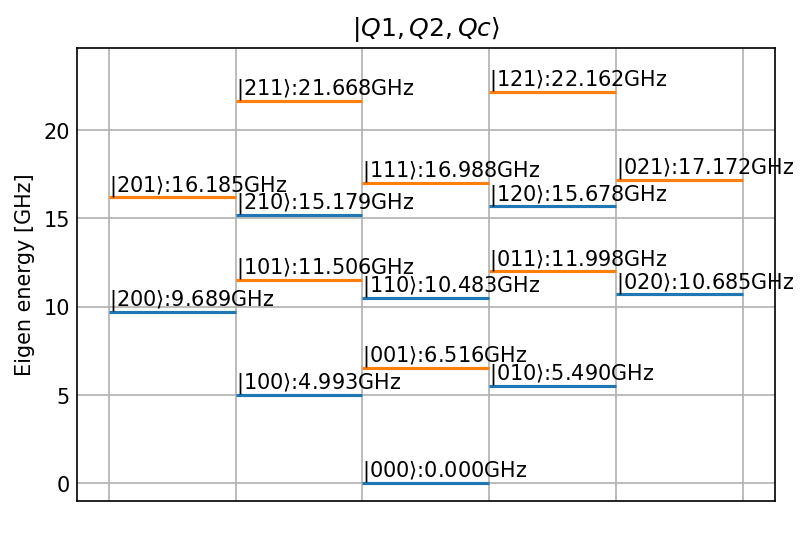

In [4]:
QQQ.plotDressedEnergyLevels(coupler_exitation_stop=1)

# Calculation of static-ZZ coupling
---

In [5]:
Nq = 3
gc1, gc2, g12 = .1, .1, .005
Q1 = scon.transmon(f01=5.0, alpha=.3, N=10, Nq=Nq)
Q2 = scon.transmon(f01=5.5, alpha=.3, N=10, Nq=Nq)

Ns = 21
fcs = np.linspace(6.8, 7.5, Ns)
sZZ = np.zeros(Ns)
eGG = np.zeros(Ns)

for i in tqdm(range(Ns)):
    _Qc = scon.transmon(f01=fcs[i], alpha=.2, N=10, Nq=Nq)
    QQQzz = scon.QQQ(Q1, Q2, _Qc, gc1, gc2, g12)
    sZZ[i] = QQQzz.staticZZ
    eGG[i] = QQQzz.effectiveCoupling

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.07it/s]


fc_zz0=7.255


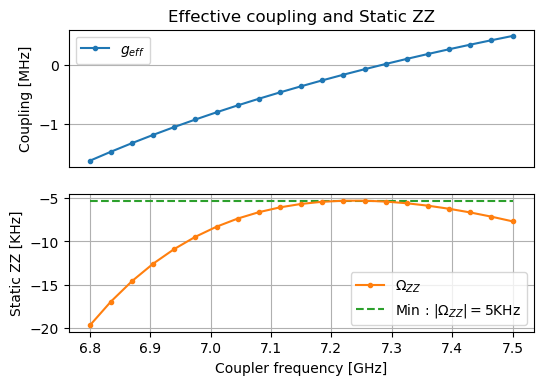

In [6]:
fig = plt.figure(2, dpi=100)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.set_title('Effective coupling and Static ZZ')
ax1.plot(fcs, eGG*1e3, marker='.', label=r'$g_{eff}$', color='tab:blue')
ax1.set_xticks([])
ax1.set_ylabel('Coupling [MHz]')
ax2.plot(fcs, sZZ*1e6, marker='.', label=r'$\Omega_{ZZ}$', color='tab:orange')
ax2.hlines(max(sZZ*1e6), fcs[0], fcs[-1], linestyle='dashed', label=r'Min : $|\Omega_{ZZ}|=$'+'{:.0f}KHz'.format(abs(max(sZZ))*1e6), color='tab:green')
# ax2.set_ylim([min(sZZ*1e6)-1e1,1e1])
ax2.set_ylabel('Static ZZ [KHz]')
ax2.set_xlabel('Coupler frequency [GHz]')

ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()

idx = np.argmax(sZZ)
fc_zz0 = fcs[idx]
print('fc_zz0={}'.format(fc_zz0))

# iSWAP gate simulation with parametric drive
---

In [7]:
fc_top, d = 8, 0
args_eq = {'f_trgt': fc_zz0, 'f0': fc_top, 'd': d}
flx_DC = scipy.optimize.fsolve(eq, pi/6, args=args_eq)[0]

Nq = 3
gc1, gc2, g12 = .1, .1, .005
Q1 = scon.transmon(f01=5.0, alpha=.3, N=10, Nq=Nq)
Q2 = scon.transmon(f01=5.5, alpha=.3, N=10, Nq=Nq)
fc = tunable_freq_transmon(flx_DC, fc_top, d)
print('f_coup_idle={} GHz'.format(fc))
Qc = scon.transmon(f01=fc, alpha=.2, N=10, Nq=Nq)
QQQ = scon.QQQ(Q1, Q2, Qc, gc1, gc2, g12)
fiSWAP = abs(QQQ.fd1 - QQQ.fd2)

H0 = QQQ.Hq1 + QQQ.Hq2 + QQQ.duff_partc
Hint = QQQ.Hintc1 + QQQ.Hintc2 + QQQ.Hint12
Nbc_t = QQQ.Nbc
H = [H0+Hint, [Nbc_t, frt2]]

ket000 = scon.ket_3Qsys(0, 0, 0, Nq, Nq, Nq)
ket100 = scon.ket_3Qsys(1, 0, 0, Nq, Nq, Nq)
ket010 = scon.ket_3Qsys(0, 1, 0, Nq, Nq, Nq)
ket110 = scon.ket_3Qsys(1, 1, 0, Nq, Nq, Nq)
ket001 = scon.ket_3Qsys(0, 0, 1, Nq, Nq, Nq)
e_ops = [ket100*ket100.dag(), ket010*ket010.dag(), ket001*ket001.dag(), ket110*ket110.dag()]

f_coup_idle=7.255 GHz


In [8]:
args_td = {}
# args_td['flx'] = flux_pulse.wf_after
args_td['flx_offset'] = flx_DC
args_td['d'] = 0
args_td['f0'] = fc_top
args_td['freq'] = 0.492 # fiSWAP # .4
print('freq_flx : {}'.format(args_td['freq']))
args_td['amp'] = .12*pi

time_sim = np.linspace(0, 2000, 201)
res = qt.mesolve(H, ket100, time_sim, args=args_td, c_ops=[],
                 e_ops=e_ops, options=qt.Options(nsteps=1e4))

freq_flx : 0.492


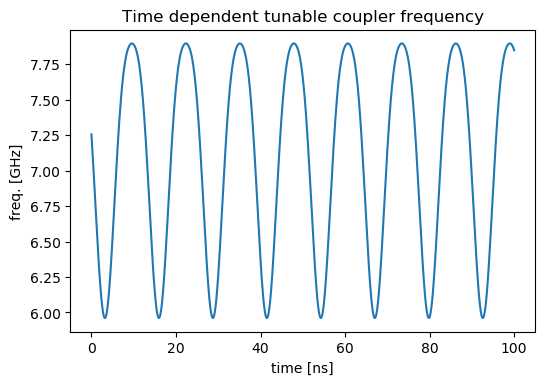

In [9]:
t_test = np.linspace(0, 100, 1001)
ft = [frt2(tt, args_td) for tt in t_test]
plt.figure('fc', dpi=100)
plt.title('Time dependent tunable coupler frequency')
plt.xlabel('time [ns]')
plt.ylabel('freq. [GHz]')
plt.plot(t_test, ft)

In [10]:
drive_freq = np.linspace(0.49, 0.51, 51)
Nfreq = len(drive_freq)
Ntime = len(time_sim)
elist_Q1 = np.zeros([Nfreq, Ntime])
elist_Q2 = np.zeros([Nfreq, Ntime])
elist_Qc = np.zeros([Nfreq, Ntime])
elist_11 = np.zeros([Nfreq, Ntime])
for i in tqdm(range(Nfreq)):
    args_td['freq'] = drive_freq[i]
    res = qt.mesolve(H, ket010, time_sim, args=args_td, c_ops=[],
                     e_ops=e_ops, options=qt.Options(nsteps=1e4))
    es = res.expect
    elist_Q1[i], elist_Q2[i], elist_Qc[i], elist_11[i] = es

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:31<00:00,  1.79s/it]


Text(0, 0.5, 'Flux-pulse frequency [GHz]')

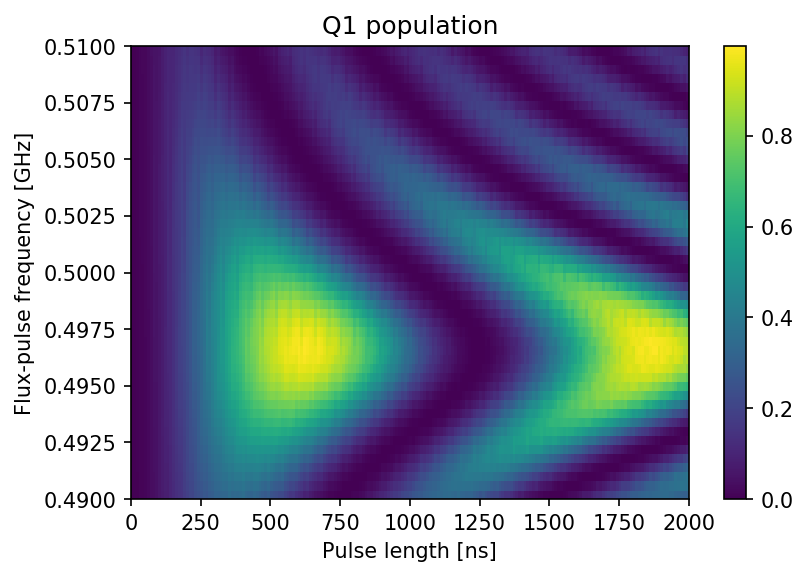

In [11]:
plt.figure(1, dpi=150)
plt.pcolor(time_sim, drive_freq, elist_Q1)
plt.colorbar()

plt.title('Q1 population')
plt.xlabel('Pulse length [ns]')
plt.ylabel('Flux-pulse frequency [GHz]')

Text(0, 0.5, 'Flux-pulse frequency [GHz]')

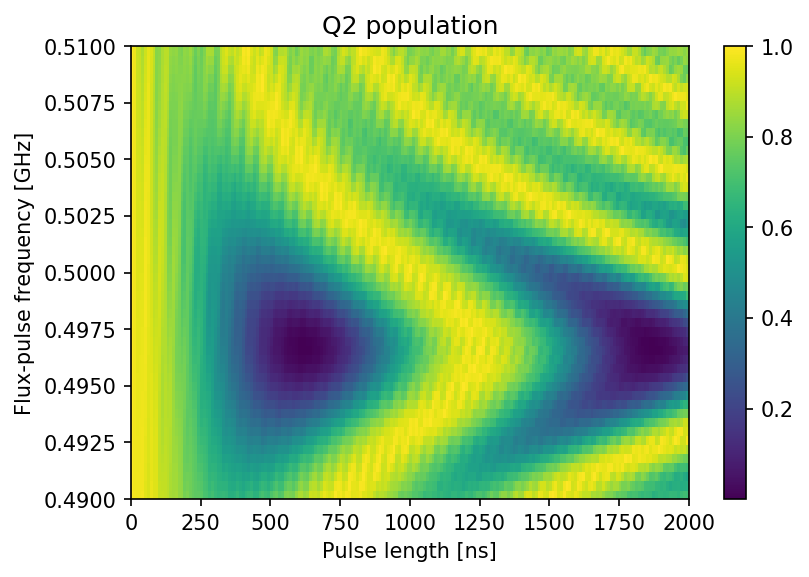

In [12]:
plt.figure(1, dpi=150)
plt.pcolor(time_sim, drive_freq, elist_Q2)
plt.colorbar()

plt.title('Q2 population')
plt.xlabel('Pulse length [ns]')
plt.ylabel('Flux-pulse frequency [GHz]')